# Analyser un réseau de personnage

## Cas d'étude : les romans d'Émile Zola

Ce document explique, illustre et utilise des bibliothèques et commandes Python pour créer des réseaux de personnages. Il s'agit d'un notebook Python qui illustre pas à pas le travail technique mis en place lors de mon stage.

Ce notebook technique accompagne mon mémoire de stage qui est lui davantage explicatif et théorique.

### Des termes importantes:

- entités: les entités (personnes, animales, lieux, etc.) dans un texte.
   
- tokens: une unité de texte. Par exemple, 'le', 'Jeanne', 'voit', '.', ces sont tous des 'tokens'. Ils se sont séparés automatiquement.

- résolution des coréférences (coreference resolution): cf. mon mémoire

- reconnaissance d'entités nommés (named entity recognition, NER) / détection des entités: cf. mon mémoire. 

Les six catégories de typage:

    * *People* (PER): *Tom Sawyer*, *her daughter*
    * *Facilities* (FAC) : *the house*, *the kitchen*
    * *Geo-political entities* (GPE): *London*, *the village*
    * *Locations* (LOC) : *the forest*, *the river*
    * *Vehicles* (VEH) : *the ship*, *the car*
    * *Organizations* (ORG) : *the army*, *the Church*

- dataframe: le nom pour la structure des données qu'utilise pandas (un librairie). C'est plus ou moins un table qui permet l'analyse, la recherche, et la transformation vites de big data.  



### Quel est notre but ?

Notre but est de créer un résau pour l'ensemble des personnages principaux d'un texte, et de pouvoir appliquer la méthode utilisée dans ce notebook à n'importe quel(s) autre(s) texte(s). Pour faire cela, nous allons utiliser les sorties de bookNLP.

Un petit sommaire pour ce que nous allons faire: 

- D'abord, nous voulons les entités principales, qui ont peut obtenir en manipulant le dataframe des entités pour obtenir les personnages (qui nous allons définir comme les entités qui sont des personnes (PER) et qui ont un nom qui est un nom propre) qui apparaissent le plus—c'est à dire, ils ont les chaines de coréférence les plus longues, avec les plus de maillons. Nous voulons donc calculer la nombre de maillons pour chaque personnage (ce que nous allons utiliser pour créer notre réseaux)

- Après ça et aussi compter le nombre des coexistences/interactions entre chaque paire des personnages parmi nos entités principales. Nous allons, pour la simplicité, définir une 'coexistence' comme un instance où deux entités apparaissent dans un 'fenêtre' de +- N tokens. C'est à dire, si personnage X apparaît dans une partie du texte, et personnage Y apparaît N tokens avant ou après, ça c'est considéré une coexistence. 

      Exemple: Personnage = Silvère, N = 5
      Silvère va à Paris avec Miette (Silvère, Miette)
              1  2 3     4    5


- Finalement, nous allons créer une structure qui s'appelle une 'dictionnaire' avec cette information, et combiner l'information de tous les 20 romans. Avec notre dictionnaire des chaines de coréférence et notre dictionnaire des coexistences, nous allons utiliser un outil qui s'appelle NetworkX pour créer un réseau.

### Étape d'installation 1: importer les bibliothèques Python

Pour pouvoir traiter les données avec Python, il faut importer les bibliothèques Python utiles aux traitements des données.

<!--- expliquer rapidement ce que fait chacune des bibliothèques ??? --->
<ul>
    <li>pandas</li> est une bibliothèque qui permet de gérer des objets de type tableaux (appelé avec le raccourci 'pd' dans le programme). 
    <li>numpy</li> est une bibliothèque qui permet de faire les calculs mathématiques rapides
    <li> networkx </li> est une bibliothèque qui permet la visualization facile des graphiques
</ul>

In [1]:
import pandas as pd
import numpy as np
import json
import networkx
import matplotlib.pyplot as plt

In [2]:
#!pip install bokeh
from bokeh.io import output_notebook, show, save

## Les données : 

Les données que nous avons à analyser sont des romans de Zola — plus précisément, les 20 romans des Rougon-Macquart.

Ils ont été annotées en Entités et coréférence automatiquement avec <i>bookNLP</i> (cf. mon mémoire de stage)...

Il est possible de visualiser les données annotées, de plusieurs manières. Par exemple :

<ul>
<li>sur un navigateur web (format html) :</li>
<li>avec SACR (format sacr - format spécifique à l'outil) cf. mon mémoire :</li>
</ul>

<!--- mettre ici une photo de l'un et/ou l'autre  - selon rapport de stage 

ici mattre html car sortie bookNLP et dans le mémoire SACR - ici faire une réf au  méoire et à SACR ?!? --->

Html


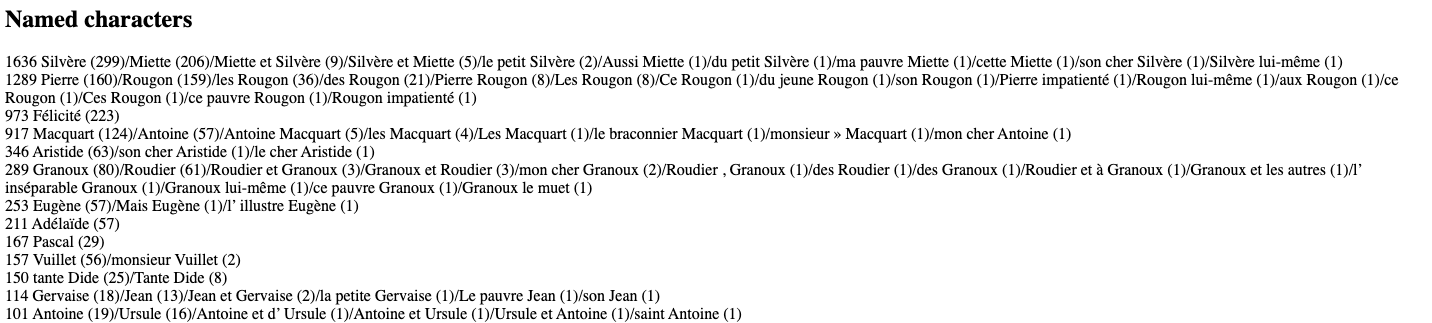

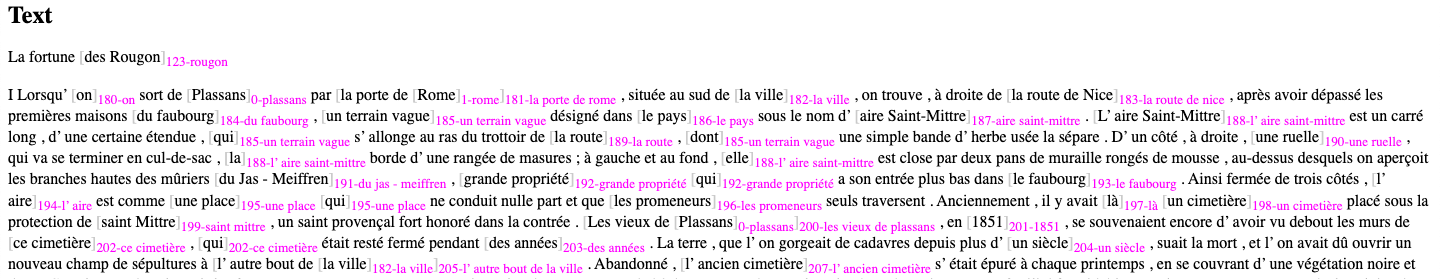

###  Étape d'installation 2: Gérer les fichiers de sortie : 

Nous ajoutons ici tous nos romans dans une liste, pour que notre programme puisse les ouvrir et commencer à faire les calculs. Pour chaque roman, nous voulons deux fichiers: les 'tokens' et les 'entities'.

In [3]:
from os import listdir
myDir = "OUTPUT_ZOLA/"
df_tokens = list()
df_entities = list()
df_books = list()
for file in sorted(listdir(myDir)):
    if "tokens" in file:
        df_token = pd.read_csv(myDir + file, delimiter="\t")
        df_tokens.append(df_token)
    elif "entities" in file: 
        df_entity = pd.read_csv(myDir + file, delimiter="\t")
        df_entities.append(df_entity)
    elif "book" in file and "html" not in file:
        with open (myDir + file, "r") as f:
            df_book = json.load(f)
        df_books.append(df_book)

nécessaire ou pas? -->
Petite note: nous allons voir partout dans le notebook qu'il y a des 'loops' (ce qui va avoir la forme de 'for X in X:'), et aussi des listes et 'indexing' (ce qui va avoir la forme de 'liste = []' et 'objet = liste[i]'), parce que nous allons former le réseau avec plusieurs œuvres. Il faut donc mettre chaque œuvre dans un liste, et utiliser un loop pour appliquer les mêmes changements à chaque œuvre dans la liste)

In [4]:
for df_entity in df_entities:
    df_entity['text'] = df_entity['text'].map(lambda x: x.lstrip('* .').rstrip('* .'))
    #clean up the trailing spaces, asterisks, periods for each token

## Étape 1: Obtenir une liste des personnes les plus importantes

### 1a: n'obtenir que les personnages principaux
Nous utilisons les capacités de pandas pour obtenir les entités qui apparaissent le plus (value_counts()) et leur lignes correspondantes dans le dataframe, et après nous faisons tomber les doubles et ceux qui n'ont pas de nom propre. Ce sont ces entités que nous allons utiliser pour créer le réseau. Finalement, nous prenons juste une certaine nombre de ces personnages (pour que nous prenions que les personnages principaux), et nous créons aussi une 'dictionaire' pour pouvoir mieux acceder aux noms des entités.

In [5]:
#first, get a list of all the different characters and the number of times they appear (including coreference)
#threshold is the number of top entities to select (before entities are filtered by PER and proper noun names, so some will be irrelevant/not wanted)
def get_top_entities(df_entities, threshold):
    top_entities_lists = []
    coref_name_dicts = []
    for i in range(len(df_entities)):
        df_entity = df_entities[i]
        top_indices = df_entity['COREF'].value_counts().index
        top_indices_list = top_indices.to_list()
        top_entities_rows = df_entity.loc[df_entity['COREF'].isin(top_indices_list)] 
        top_entities_list = top_entities_rows.drop_duplicates('COREF')       
        top_entities_list = top_entities_list.loc[(top_entities_list['cat'] == 'PER') & (top_entities_list['prop'] == 'PROP')]       
        top_entities_list = top_entities_list.drop_duplicates('text')       
        top_entities_list = top_entities_list.loc[top_entities_list['COREF'].isin(top_indices_list[0:threshold])]
        coref_name_dict = top_entities_list.set_index('COREF').to_dict()['text']
        top_entities_lists.append(top_entities_list)
        coref_name_dicts.append(coref_name_dict)
    return top_entities_lists, coref_name_dicts

top_entities_lists, coref_name_dicts = get_top_entities(df_entities, 20)

In [6]:
print(top_entities_lists[0])
print(coref_name_dicts[0])

      COREF  start_token  end_token  prop  cat        text
0       123            2          3  PROP  PER  des Rougon
297     126         4020       4020  PROP  PER     Silvère
342     127         4344       4345  PROP  PER  tante Dide
1961    140        17108      17108  PROP  PER    Adélaïde
2043    141        17716      17716  PROP  PER    Macquart
2822    146        22953      22953  PROP  PER    Félicité
3401    147        26879      26879  PROP  PER      Eugène
3494    148        27589      27589  PROP  PER    Aristide
3760    150        29203      29203  PROP  PER      Pascal
4551    159        34830      34830  PROP  PER     Vuillet
4588    160        35104      35104  PROP  PER     Roudier
{123: 'des Rougon', 126: 'Silvère', 127: 'tante Dide', 140: 'Adélaïde', 141: 'Macquart', 146: 'Félicité', 147: 'Eugène', 148: 'Aristide', 150: 'Pascal', 159: 'Vuillet', 160: 'Roudier'}


Ci-dessus nous voyons le 'top_entities_list', une liste des entités le plus communs, et aussi le 'coref_name_dicts', ce qui permet l'accès facile aux noms des personnages en utilisant leur numéro de coréférence, un numéro d'identification unique pour chaque entité.

### Problème 1: Un personnage reconnu comme étant plusieurs
Nous avons trouvé un problème en analysant les sorties de BookNLP où le modèle peut penser que les différentes mentions du même personnage sont des différents personnages; par exemple avec le personnage Pierre Rougon, les mentions Pierre, Pierre Rougon, et Monsieur Rougon peuvent être compté comme des différents personnages. Ce problème est particulièrement évident quand nous combinons plusieurs romans. 

Pour combattre ce problème et avoir la meilleure chance de caracteriser correctement le personnage à travers les romans, nous allons nommer les personnages avec leur nom qui apparaît le plus, ce qui est possible avec les informations qui viennent des sorties de BookNLP.

In [7]:
#for the purposes of making sure that all characters across all books have the best chance to be predicted to be the same character,
#we want to make sure that entity names match up across books.
#to do this, we will 'fix' our top_entities_list by changing all the names to the exact mention that occurs the most often
def fix_entity_names(df_books, top_entities_lists, coref_name_dicts):
    fixed_name_dicts = []
    for i in range(len(df_entities)):
        fixed_name_dict = {}
        df_book = df_books[i]
        top_entities_list = top_entities_lists[i]
        coref_name_dict = coref_name_dicts[i]
        entity_count = 0
        index = 0
        while entity_count < len(top_entities_list):
            curr_char = df_book['characters'][index]
            if curr_char['id'] in coref_name_dict:          
                fixed_name_dict[top_entities_list.loc[top_entities_list['COREF'] == curr_char['id']]['text'].iloc[0]] = curr_char['mentions']['proper'][0]['n'].title()      
                top_entities_list.loc[top_entities_list['COREF'] == curr_char['id'], 'text'] = curr_char['mentions']['proper'][0]['n'].title()
                entity_count += 1
            index+=1
        top_entities_lists[i] = top_entities_list
        coref_name_dicts[i] = top_entities_list.set_index('COREF').to_dict()['text']
        fixed_name_dicts.append(fixed_name_dict)
    return top_entities_lists, coref_name_dicts, fixed_name_dicts
fixed_name_dicts = {}   
fix_names = True
if fix_names:
    top_entities_lists, coref_name_dicts, fixed_name_dicts = fix_entity_names(df_books, top_entities_lists, coref_name_dicts)

In [8]:
print(top_entities_lists[0])

      COREF  start_token  end_token  prop  cat        text
0       123            2          3  PROP  PER      Pierre
297     126         4020       4020  PROP  PER     Silvère
342     127         4344       4345  PROP  PER  Tante Dide
1961    140        17108      17108  PROP  PER    Adélaïde
2043    141        17716      17716  PROP  PER    Macquart
2822    146        22953      22953  PROP  PER    Félicité
3401    147        26879      26879  PROP  PER      Eugène
3494    148        27589      27589  PROP  PER    Aristide
3760    150        29203      29203  PROP  PER      Pascal
4551    159        34830      34830  PROP  PER     Vuillet
4588    160        35104      35104  PROP  PER     Granoux


On voit que 'des Rougon' est changé à Pierre.

### Problème 2: Plusieurs personnages reconnus comme n'étant qu'un

Nous avons trouvé un autre problème en analysant les sorties de BookNLP qui est l'inverse de l'autre (cf. 'Les problèmes avec le BookNLP français' dans mon mémoire): il y a un possibilité de faire disparaître les personnages dans l'annotation. 

Pour essayer de résoudre cela, nous allons garder les deux mentions les plus communs et leur taille pour les personnages pour lesquels le modèle a du mal à prédire leur genre, qui signifie probablement que plusieurs personnages de genre différent sont mélangés. Nous allons utiliser les informations gardées pour récréer plus tard ces personnages dans le réseau. Cependant, nous sommes conscient du fait que cela peut échouer à résoudre les cas où deux personnages du même sexe sont mélangés. 

In [9]:
#add booknlp's inferred gender to a dictionary for use in the network
#for those who do not have a strong prediction, we will add the names of the top 2 characters to make
#2 nodes for this character (because in our debugging we found it is likely that 2 characters are mixed together)
def add_gender(df_books, top_entities_lists, coref_name_dicts):
    gender_dict = {} #maps name to inferred gender in .book
    errors_dict = {} #if gender is 'error' (inference 'max' is <.8), put in this dict and map name to 2nd most common mention name, proportion of entity1 count, entity2 count
    for i in range(len(df_books)):
        df_book = df_books[i]
        top_entities_list = top_entities_lists[i]
        coref_name_dict = coref_name_dicts[i]
        entity_count = 0 # to count the number of characters matched so far
        character_index = 0 #to loop thru characters in book
        while entity_count < len(top_entities_list):
            curr_char = df_book['characters'][character_index]
            if curr_char['id'] in coref_name_dict:
                if curr_char['g']['max'] >= .8:
                    gender_dict[coref_name_dict[curr_char['id']]] = curr_char['g']['argmax']
                else:
                    #we want to store some information to use later, when separating the 2 characters, notably their name and how much they appear
                    #errors_list[0] = 2nd most common entity name (entity2)
                    #errors_list[1] = proportion of entity1 (entity1 count / entity1 count + entity2 count) * total count
                    #errors_list[2] = proportion of entity2
                    errors_list = []
                    curr_char_prop = curr_char["mentions"]["proper"]
                    if len(curr_char_prop) > 1 and curr_char_prop[0]['n'] not in curr_char_prop[1]['n']:
                        errors_list.append(curr_char_prop[1]['n'])
                        errors_list.append(round(curr_char_prop[0]['c'] / (curr_char_prop[0]['c'] + curr_char_prop[1]['c']) * curr_char["count"], 0))
                        errors_list.append(round(curr_char_prop[1]['c'] / (curr_char_prop[0]['c'] + curr_char_prop[1]['c']) * curr_char["count"], 0))
                        errors_dict[coref_name_dict[curr_char['id']]] = errors_list
                        if curr_char['g']['argmax'] == 'il/le':
                            gender_dict[errors_list[0]] = 'elle/la'
                        else:
                            gender_dict[errors_list[0]] = 'il/le'
                    gender_dict[coref_name_dict[curr_char['id']]] = curr_char['g']['argmax']
                entity_count += 1
            character_index += 1
    return gender_dict, errors_dict
gender_dicts, errors_dict = add_gender(df_books, top_entities_lists, coref_name_dicts)

In [10]:
print(errors_dict)

{'Silvère': ['Miette', 969.0, 667.0], 'Renée': ['Maxime', 1499.0, 1053.0], 'Laure': ['Sylvia', 55.0, 46.0], 'Marjolin': ['Cadine', 217.0, 163.0], 'Mme François': ['madame François', 133.0, 7.0], 'M. Lebigre': ['monsieur Lebigre', 119.0, 6.0], 'Mme Rougon': ['Rougon', 125.0, 62.0], 'Albine': ['Serge', 1571.0, 1218.0], 'Clorinde': ['M. de Marsy', 1422.0, 263.0], 'Madame Correur': ['Madame Correur', 226.0, 99.0], 'M. Bouchard': ['madame Bouchard', 135.0, 91.0], 'Les Charbonnel': ['madame Charbonnel', 103.0, 95.0], 'M. De Plouguern': ['M. Charbonnel', 160.0, 18.0], 'Gervaise': ['Coupeau', 985.0, 536.0], 'Lantier': ['Coupeau', 624.0, 392.0], 'Mme Lorilleux': ['Lorilleux', 298.0, 231.0], 'Mme Boche': ['Boche', 140.0, 118.0], 'Rosalie': ['Zéphyrin', 493.0, 176.0], 'Monsieur Rambaud': ['Monsieur Rambaud', 211.0, 111.0], 'Fauchery': ['Daguenet', 462.0, 193.0], 'Mignon': ['Rose', 285.0, 202.0], 'Georges': ['madame Hugon', 222.0, 69.0], 'Nana': ['Rose', 199.0, 27.0], 'Berthe': ['Hortense', 1315.0

### 1b: obtenir le nombre de fois que chaque personnage apparaît
Pour créer les nœuds du réseau, nous voulons le nombre de fois que chaque personnage apparaît. Nous allons faire cela en identifiant les entités en utilisant leur numéro de coréférence (par exemple, chaque apparition de Silvère, bien qu'il soit appelé 'Silvère', 'il', 'lui', etc., fera appel à cet numéro).

In [11]:
#top_entities_list is df of most common entities (as returned by get_top_entities)
#df_entities is df with all entities
#returns a dictionary that maps top entity name : number of times it appears (including coreference)
def get_top_entities_counts(top_entities_lists, df_entities, coref_name_dicts):
    top_entities_list_indices_list = []
    top_entities_counts_dicts = []
    for i in range(len(top_entities_lists)): 
        top_entities_list = top_entities_lists[i]
        df_entity = df_entities[i]
        coref_name_dict = coref_name_dicts[i]
        top_entities_list_indices = top_entities_list['COREF'] #all the top COREF numbers
        top_entities_counts = df_entity.loc[df_entity['COREF'].isin(top_entities_list_indices)]
        top_entities_counts = top_entities_counts['COREF'].value_counts()
        #counts for the amount of times each top entity appears     
        top_entities_counts_dict = {}
        for entity_coref, name in coref_name_dict.items():   
            #create a dictionary that maps name to number of appearances
            top_entities_counts_dict[name] = top_entities_counts.loc[entity_coref]   
        top_entities_list_indices_list.append(top_entities_list_indices)
        top_entities_counts_dicts.append(top_entities_counts_dict)
    return top_entities_list_indices_list, top_entities_counts_dicts
top_entities_list_indices_list, top_entities_counts_dicts = get_top_entities_counts(top_entities_lists, df_entities, coref_name_dicts)

In [12]:
print(top_entities_counts_dicts[0])

{'Pierre': 1293, 'Silvère': 1637, 'Tante Dide': 150, 'Adélaïde': 211, 'Macquart': 918, 'Félicité': 973, 'Eugène': 253, 'Aristide': 346, 'Pascal': 167, 'Vuillet': 157, 'Granoux': 289}


## Étape 2: obtenir le nombre de coéxistences

Pour obtenir le nombre des 'coéxistences' entre les personnages, comme nous avons décrit au-dessus, nous allons voir les N tokens avant et après chaque mention d'une entité. Nous allons commencer avec les N tokens après. Nous faisons un 'loop' et nous prenons chaque personnage qui apparaît dans cette 'fênetre'. Si le personnage est l'un des 'top entitiés' (ceux qui apparaissent le plus dans le texte), nous incrementons le compte entre cette paire des personnages. C'est important de noter que nous prenons le personnage original pour compter ces coexistences en utilisant les numéros de coréférence. Les comptes des coexistences sont gardés dans une dictionnaire (il y a une entrée pour chaque paire possible entre les personnages principaux). Après que le 'loop' se termine quand nous avons vu tous les personnages qui apparaissent dans ce fênetre, nous faisons un autre loop avec les N tokens avant.

In [13]:
#char_dict - character dictionary that counts interactions betewen 2 entities.  *assumed to already have empty dictionaries that account for every link*
#  char_dict[entity1][entity2] will be the amount of co-occurrences within windows of n tokens of entity1, entity2
#entity_index - index of top_entities_rows where your given entity is
def get_pers_within_n_tokens(df_tokens, df_entities, top_entities_list, fixed_name_dict, n, char_dict, entity_index): 
    #using our given entity_index, find the start and end token of the entity
    start_token_index = df_entities.iloc[entity_index]['start_token']
    end_token_index = df_entities.iloc[entity_index]['end_token']
    #keep track of the entity we are starting on
    if fix_names:
        orig_entity = fixed_name_dict[df_entities.loc[df_entities['COREF'] == df_entities.iloc[entity_index]['COREF']].iloc[0]['text']] 
    else:
        orig_entity = df_entities.loc[df_entities['COREF'] == df_entities.iloc[entity_index]['COREF']].iloc[0]['text']
    curr_entity_index = entity_index
    curr_entity = orig_entity
    curr_end_token_index = df_entities.iloc[curr_entity_index]['end_token']
    #starting token index is end_token number of given entity
    #while loop to find entities with end token >= index-n
    while curr_end_token_index >= end_token_index-n and curr_end_token_index >= 0:
        if curr_entity in fixed_name_dict:
            curr_entity = fixed_name_dict[curr_entity]
        #check to see if the entity we are on is not our original entity, and if it's in the list of top entities
        if curr_entity != orig_entity and curr_entity in char_dict:
            char_dict[orig_entity][curr_entity] += 1
        if curr_entity_index == 0:
            break
        curr_entity_index -= 1
        curr_end_token_index = df_entities.iloc[curr_entity_index]['end_token']
        #find the end token of the previous entity
        curr_entity = df_entities.loc[df_entities['COREF'] == df_entities.iloc[curr_entity_index]['COREF']].iloc[0]['text']
        #update the entity name of curr entity. this long expression gives us the original name of the entity using its first appearance, 
        #so it works even if it is a coreference
    #now, do a while loop for entities with start token <= index+n
    curr_entity_index = entity_index
    curr_start_token_index = df_entities.iloc[curr_entity_index]['start_token']
    #starting token index is start_token number of given entity
    curr_entity = orig_entity
    while curr_start_token_index <= start_token_index+n and curr_start_token_index < len(df_tokens):
        if curr_entity in fixed_name_dict:
            curr_entity = fixed_name_dict[curr_entity]
        if curr_entity != orig_entity and curr_entity in char_dict:
            char_dict[orig_entity][curr_entity] += 1

        curr_entity_index += 1
        if curr_entity_index >= len(df_entities):
            break
        curr_start_token_index = df_entities.iloc[curr_entity_index]['start_token']
        curr_entity = df_entities.loc[df_entities['COREF'] == df_entities.iloc[curr_entity_index]['COREF']].iloc[0]['text']

    return char_dict

## Étape 3: Créer le réseau

### 3a: créer des structures pour créer le réseau
Nous créons une dictionnaire qui a le nombre de coexistences entre chaque personnage et en prenant tous lignes du dataframe où apparaît une 'top entité' pour appliquer notre fonction.

In [14]:
#now that we have this list, we want to find every instance where each character appears, and put windows of 
#+- N tokens around each
top_entities_rows_list = []
for i in range(len(df_entities)):
    df_entity = df_entities[i]
    top_entities_list_indices = top_entities_list_indices_list[i]
    top_entities_rows = df_entity.loc[df_entity['COREF'].isin(top_entities_list_indices)] #gives us all rows where a top entity appears
    top_entities_rows_list.append(top_entities_rows)
    
#create dictionary for each possible link between characters
def create_characters_dict(top_entities_lists):
    characters_dicts = []
    for top_entities_list in top_entities_lists:
        characters_dict = {}
        for entity1 in top_entities_list['text']:
            characters_dict[entity1] = {}
            for entity2 in top_entities_list['text']:
                if entity1 != entity2:
                    characters_dict[entity1][entity2] = 0
        characters_dicts.append(characters_dict)
    return characters_dicts

characters_dicts = create_characters_dict(top_entities_lists)

#run get_pers_within_n_tokens on every row of top_entities_rows
for i in range(len(top_entities_rows_list)):
    df_token = df_tokens[i]
    df_entity = df_entities[i]
    top_entities_list = top_entities_lists[i]
    characters_dict = characters_dicts[i]
    fixed_name_dict = {}
    if fix_names:
        fixed_name_dict = fixed_name_dicts[i]
    top_entities_rows_list[i].apply(lambda x: get_pers_within_n_tokens(df_token, df_entity, top_entities_list, fixed_name_dict, 20, characters_dict, x.name), axis=1) 

In [15]:
print(characters_dicts[0])

{'Pierre': {'Silvère': 45, 'Tante Dide': 20, 'Adélaïde': 101, 'Macquart': 238, 'Félicité': 363, 'Eugène': 47, 'Aristide': 68, 'Pascal': 17, 'Vuillet': 55, 'Granoux': 142}, 'Silvère': {'Pierre': 46, 'Tante Dide': 113, 'Adélaïde': 14, 'Macquart': 55, 'Félicité': 10, 'Eugène': 0, 'Aristide': 7, 'Pascal': 88, 'Vuillet': 2, 'Granoux': 0}, 'Tante Dide': {'Pierre': 20, 'Silvère': 66, 'Adélaïde': 3, 'Macquart': 33, 'Félicité': 0, 'Eugène': 0, 'Aristide': 0, 'Pascal': 7, 'Vuillet': 0, 'Granoux': 0}, 'Adélaïde': {'Pierre': 101, 'Silvère': 14, 'Tante Dide': 4, 'Macquart': 97, 'Félicité': 5, 'Eugène': 0, 'Aristide': 0, 'Pascal': 0, 'Vuillet': 0, 'Granoux': 0}, 'Macquart': {'Pierre': 243, 'Silvère': 55, 'Tante Dide': 46, 'Adélaïde': 97, 'Félicité': 169, 'Eugène': 0, 'Aristide': 8, 'Pascal': 7, 'Vuillet': 0, 'Granoux': 14}, 'Félicité': {'Pierre': 365, 'Silvère': 10, 'Tante Dide': 2, 'Adélaïde': 5, 'Macquart': 169, 'Eugène': 101, 'Aristide': 106, 'Pascal': 51, 'Vuillet': 31, 'Granoux': 35}, 'Eugène':

Nous utilisons une fonction de la bibliothèque pandas pour créer un 'dataframe' avec cette dictionnaire de coexistences.

Comme continuation du problème 2, nous allons copier les informations des coexistences des quelques personnages pour récréer les personnages qui sont disparus. 

In [16]:
#now that we have a full dictionary, we want to turn that into a dataframe and then a network. we will also use this opportunity
#to duplicate the rows to fix for the characters in error_list
interactions_dfs = []
error_set = set(errors_dict)
for i in range(len(characters_dicts)):
    characters_dict = characters_dicts[i]
    #we need to loop thru all characters_dicts and find all characters that are in errors_dict
    for name in error_set.intersection(characters_dict):     
        #now, we want to create a duplicate row for the character in error_list
        #for example, for silvere/miette we want to make a duplicate row of silvere for miette
        error_list = errors_dict[name]
        characters_dict[error_list[0]] = characters_dict[name].copy()
        #afterwards, we need to update every single entry in characters_dict to add dict[i][miette], which will be the same value as for silvere
        #so loop thru every other character in the dict
        for char, d in characters_dict.items():
            if char != name and char != error_list[0]:               
                d[error_list[0]] = d[name]
    interactions_df = pd.DataFrame.from_dict(characters_dict)
    interactions_dfs.append(interactions_df)

In [17]:
print(interactions_dfs[0])

            Pierre  Silvère  Tante Dide  Adélaïde  Macquart  Félicité  Eugène  \
Silvère       45.0      NaN        66.0      14.0      55.0      10.0     0.0   
Tante Dide    20.0    113.0         NaN       4.0      46.0       2.0     0.0   
Adélaïde     101.0     14.0         3.0       NaN      97.0       5.0     0.0   
Macquart     238.0     55.0        33.0      97.0       NaN     169.0     0.0   
Félicité     363.0     10.0         0.0       5.0     169.0       NaN   101.0   
Eugène        47.0      0.0         0.0       0.0       0.0     101.0     NaN   
Aristide      68.0      7.0         0.0       0.0       8.0     106.0    55.0   
Pascal        17.0     88.0         7.0       0.0       7.0      51.0     1.0   
Vuillet       55.0      2.0         0.0       0.0       0.0      31.0    13.0   
Granoux      142.0      0.0         0.0       0.0      14.0      35.0    16.0   
Miette        45.0      NaN        66.0      14.0      55.0      10.0     0.0   
Pierre         NaN     46.0 

### 3b: combiner les structures des 20 romans
Nous utilisons pandas pour mettre ensemble tous les dataframes de coexistence de tous les romans; pour les personnages qui apparaissent plus d'une fois, nous allons les fusionner dans un seul nœud (en additionnant tous les fois où ils apparaissent), et le nombre de leurs coexistences aussi. 

Par exemple:

    Roman 1:
    Jean: 5 mentions          
    Jean - Eugène: 2 fois
    Jean - Hélène: 3 fois

    Roman 2: 
    Jean: 10 mentions
    Jean - Hélène: 4 fois
    Jean - Silvère: 3 fois

    Final:
    nœud Jean: 15 mentions
    lien Jean - Eugène: épaisseur 2
    lien Jean - Hélène: épaisseur 7
    lien Jean - Silvère: épaisseur 3

Comme continuation du problème 2, nous allons ajuster les tailles des personnages fusionnés selon leur proportion.

In [18]:
#merge interactions dataframes
merged_interactions_df = pd.concat(interactions_dfs, join='outer', axis=1)
merged_interactions_df = merged_interactions_df.groupby(level=0, axis=1).sum()
#merge top_entities_counts dictionaries
merged_top_entities_counts_dict = {}
for d in top_entities_counts_dicts:
    for entity, count in d.items():
        merged_top_entities_counts_dict[entity] = merged_top_entities_counts_dict.get(entity, 0) + count
for name, error_list in errors_dict.items():
    if error_list[1] < merged_top_entities_counts_dict[name] * .4: 
        #unelegant solution, which accounts for entities that have errors with multiple novels, in which they end up getting shrunk
        #because the program only takes account of the proportion for errors for the latest appearance in a novel,
        #which could end up getting rid of a lot of its mentions.
        merged_top_entities_counts_dict[name] += error_list[1]
    else:
        merged_top_entities_counts_dict[name] = error_list[1]
    if error_list[0] in merged_top_entities_counts_dict:
        merged_top_entities_counts_dict[error_list[0]] += error_list[2]
    else:
        merged_top_entities_counts_dict[error_list[0]] = error_list[2]

In [25]:
print(merged_interactions_df)

                       Adélaïde  Albine  Angèle  Angélique  Antonia  Aristide  \
Silvère                    14.0     0.0     0.0        0.0      0.0       7.0   
Tante Dide                  4.0     0.0     0.0        0.0      0.0       0.0   
Adélaïde                    0.0     0.0     0.0        0.0      0.0       0.0   
Macquart                   97.0     0.0     0.0        0.0      0.0       8.0   
Félicité                    5.0     0.0     0.0        0.0      0.0     106.0   
...                         ...     ...     ...        ...      ...       ...   
Maurice                     0.0     0.0     0.0        0.0      0.0       0.0   
Martine                     0.0     0.0     0.0        0.0      0.0       0.0   
La Vieille Mme Rougon       0.0     0.0     0.0        0.0      0.0       0.0   
Charles                     0.0     0.0     0.0        0.0      0.0       0.0   
Ramond                      0.0     0.0     0.0        0.0      0.0       0.0   

                       Augu

In [26]:
print(merged_top_entities_counts_dict)

{'Pierre': 1293, 'Silvère': 969.0, 'Tante Dide': 252, 'Adélaïde': 211, 'Macquart': 918, 'Félicité': 1449, 'Eugène': 346, 'Aristide': 346, 'Pascal': 167, 'Vuillet': 157, 'Granoux': 289, 'Louise': 1013.0, 'Laure': 55.0, 'Renée': 1499.0, 'Saccard': 3580, 'M. Toutin - Laroche': 105, 'M. Hupel De La Noue': 157, 'Mme Sidonie': 352, 'Angèle': 133, 'Larsonneau': 243, 'Mme François': 133.0, 'Florent': 2485, 'La Sarriette': 291, 'Mlle Saget': 512, 'M. Lebigre': 119.0, 'Marjolin': 217.0, 'Claude': 1476.0, 'Gavard': 517, 'Quenu': 255, 'Lisa': 826, 'Pauline': 754.0, 'Charvet': 145, 'Muche': 130, 'Marthe': 2827, 'Désirée': 640, 'M. Rastoil': 177, 'Mme De Condamin': 209, 'Mouret': 1312, 'Olympe': 641, 'M. De Condamin': 195, 'Mme Rougon': 125.0, 'Mme Paloque': 175, 'Trouche': 396, 'La Teuse': 526, 'Jésus': 154, 'Frère Archangias': 191, 'Rosalie': 493.0, 'Albine': 1571.0, 'M. Kahn': 430, 'Rougon': 3385.0, 'M. La Rouquette': 157, 'Madame Correur': 325.0, 'Les Charbonnel': 103.0, 'Clorinde': 1422.0, 'M. 

### 3c: créer le réseau avec NetworkX
Finalement, nous utilisons la bibliothèque networkx pour créer les visualization des graphes.

In [20]:
#now let's make the network
G=networkx.from_pandas_adjacency(merged_interactions_df)
#remove edges from a character to themself
for entity in merged_top_entities_counts_dict.keys():
    if G.has_edge(entity, entity):
        G.remove_edge(entity, entity)
pos = networkx.spring_layout(G)
labels = networkx.get_edge_attributes(G,'weight')


Nous ajoutons ici des informations à chaque nœud comme le nombre de fois que ce personnage apparaît, les romans où le personnage est présent, et une couleur pour représenter son sexe inféré.

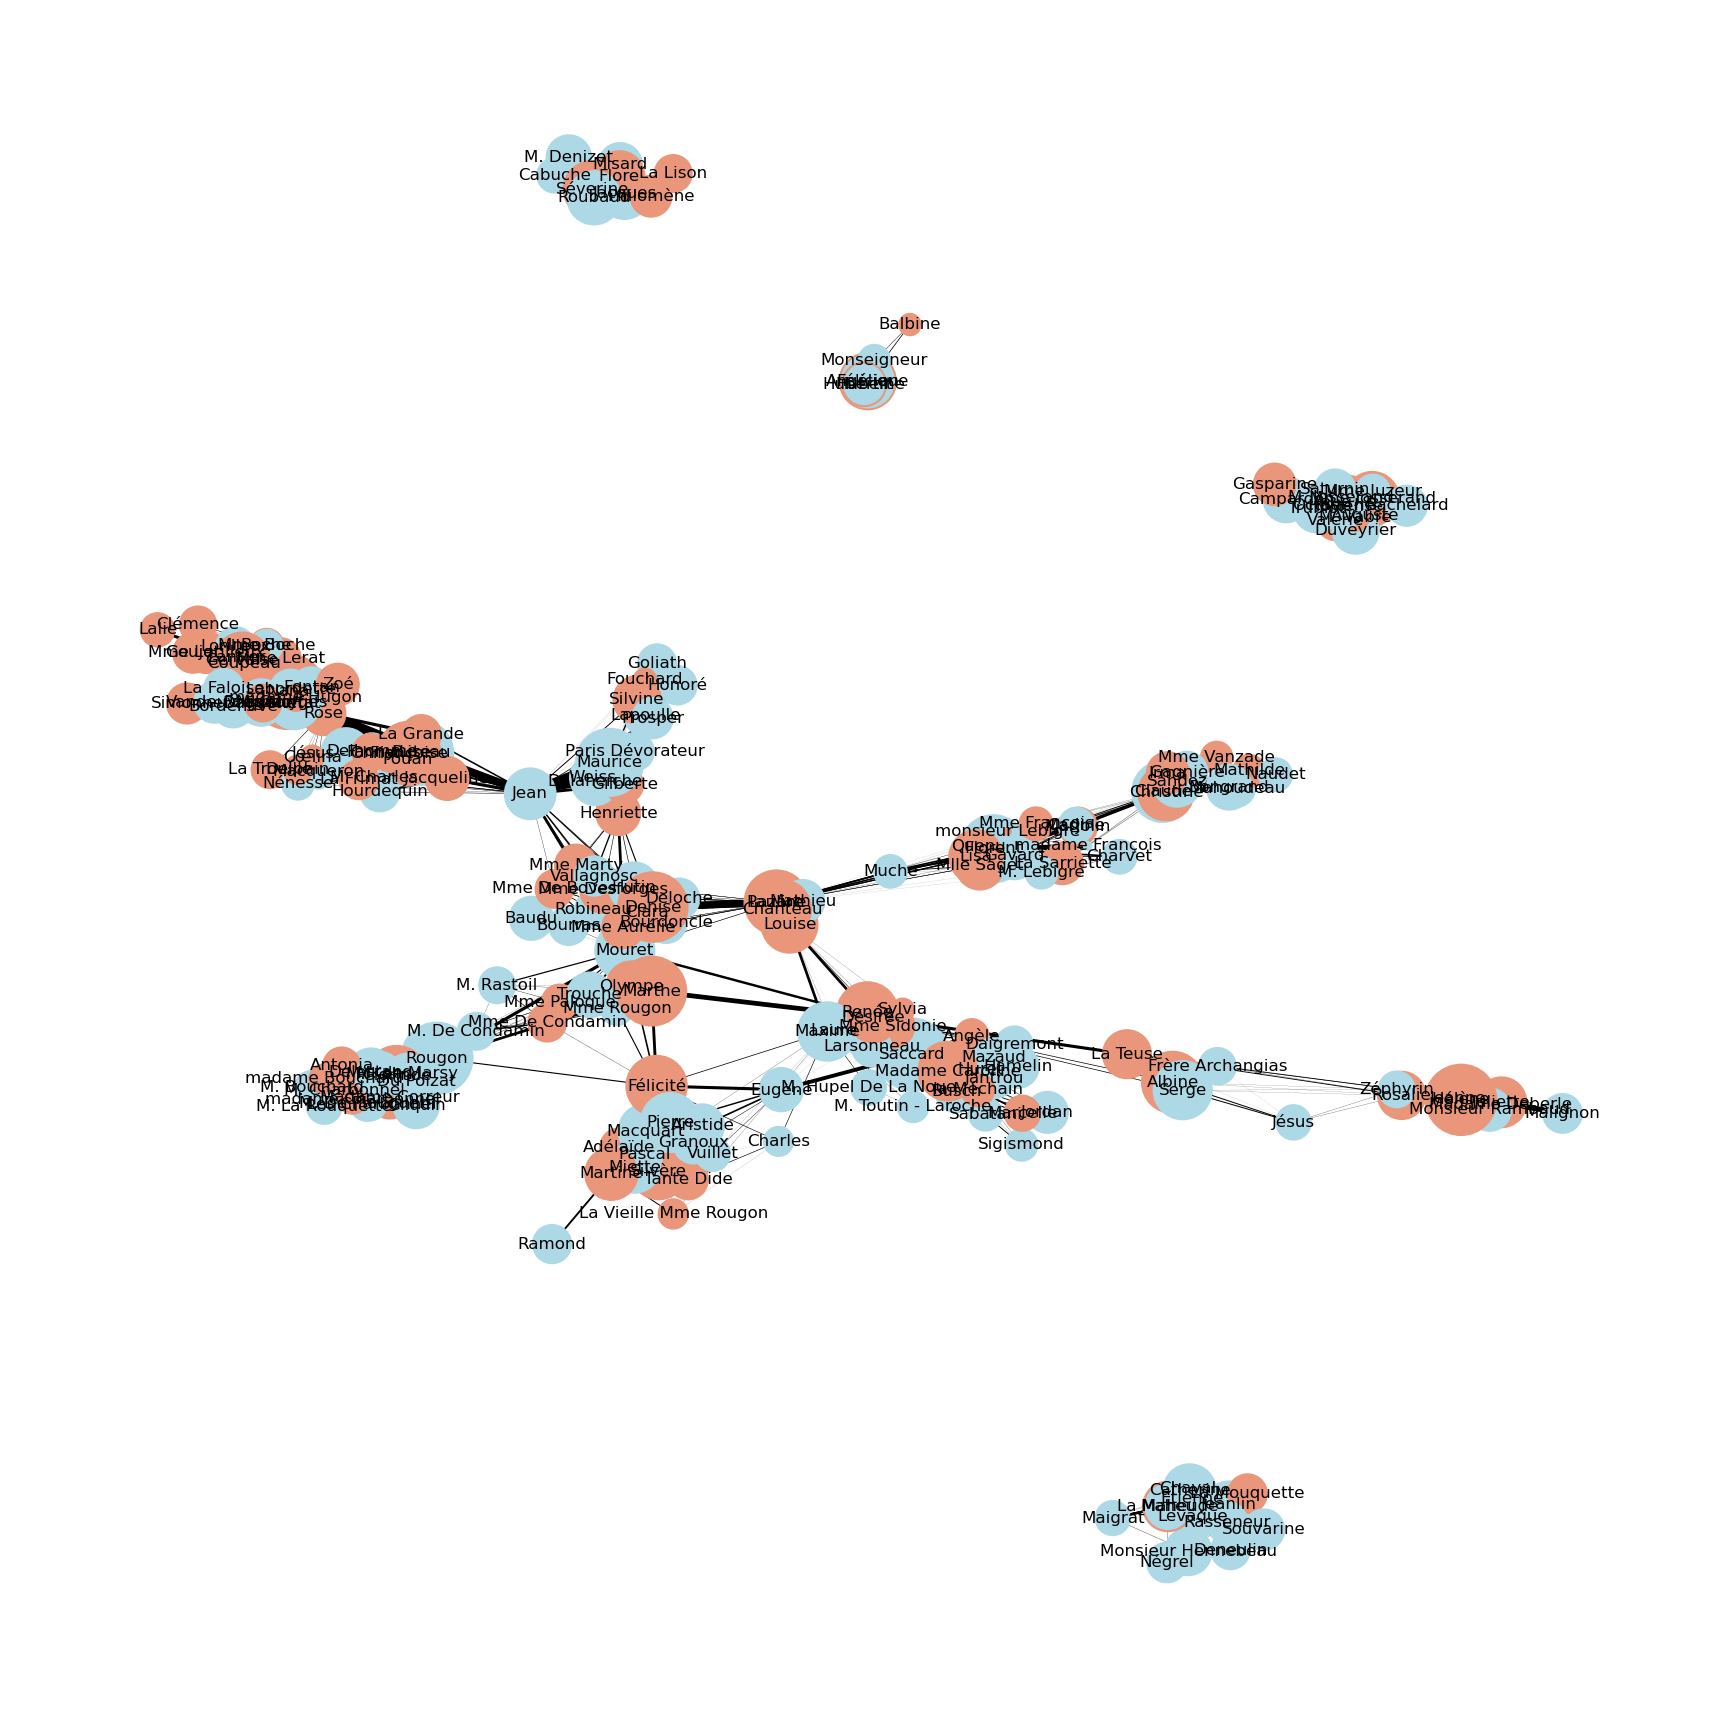

In [21]:
#this method will both add the size/weight of each node, as well as colors based on their inferred gender and 
#which novels they appear in
book_dict = {1: "La Fortune des Rougon", 2: "La Curée", 3: "Le Ventre de Paris", 4: "La Conquête de Plassans", 5: "La Faute de l'abbé Mouret", 
            6: "Son Excellence Eugène Rougon", 7: "L'Assommoir", 8: "Une page d'amour", 9: "Nana", 10: "Pot-Bouille", 
            11: "Au Bonheur des Dames", 12: "La Joie de vivre", 13: "Germinal", 14: "L'Œuvre", 15: "La Terre",
            16: "Le Rêve", 17: "La Bête humaine", 18: "L'Argent", 19: "La Débâcle", 20: "Le Docteur Pascal"}


def add_nodes(G, top_entities_counts_dict, color1='lightblue', color2='darksalmon'):
    node_sizes = []
    color_map = [] 
    color_dict = {}
    novels_dict = {} #list of all the romans this character appears in
    sorted_nodes = sorted([top_entities_counts_dict[node] for node in G.nodes()], reverse=True)
    for node in G.nodes():
        size = top_entities_counts_dict[node]
        novels = ""
        color = color1
        gender = gender_dicts[node]
        if gender == 'il/le':
            color_map.append(color1)
            color_dict[node] = color1
            node_sizes.append(np.log(size) ** 3 * 5)
        elif gender == 'elle/la':
            color_map.append(color2)
            color_dict[node] = color2
            node_sizes.append(np.log(size) ** 3 * 5)
        else:
            color_map.append(color3)
            color_dict[node] = color3
            node_sizes.append(np.log(size) ** 3 * 5)
        for i in range(len(characters_dicts)):
            character_dict = characters_dicts[i]
            if node in character_dict:
                novels += book_dict[i + 1] + ", "
        novels_dict[node] = novels[:-2]
    
    return node_sizes, color_map, color_dict, novels_dict
node_sizes, color_map, color_dict, novels_dict = add_nodes(G, merged_top_entities_counts_dict)
edges = G.edges()
max_edge = max([G[u][v]['weight'] for u,v in edges])
weights = [(G[u][v]['weight'] / max_edge) * 30 for u,v in edges] #normalizing a bit, currently arbitrary
plt.figure(2,figsize=(17,17)) 
networkx.draw(G, pos, width=weights,with_labels=True, node_size=node_sizes, node_color=color_map)

Ici, nous voyons un réseau des personnages. Nous voyons tous les personnages importants ici (plus ou moins), où les personnages les plus importants, qui ont le plus de maillons ont les nœuds les plus grands et ont des couleurs différents selon leur taille, et les liens montrent où se trouve le plus de cooccurrences.


In [22]:
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, EdgesAndLinkedNodes, NodesAndLinkedEdges, LabelSet
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8
from bokeh.transform import linear_cmap
from networkx.algorithms import community

In [23]:
degrees = dict(networkx.degree(G))
networkx.set_node_attributes(G, name='degree', values=degrees)
adjusted_top_entities_counts_dict = dict([(node, (np.log(size)**2) + 3) for node, size in merged_top_entities_counts_dict.items()])
adjusted_node_size = adjusted_top_entities_counts_dict 
networkx.set_node_attributes(G, name='adjusted_node_size', values=adjusted_node_size)
networkx.set_node_attributes(G, name='node_size', values=merged_top_entities_counts_dict)
names = {}
for name in list(G.nodes()):
    names[name] = name #unelegant solution but it works
networkx.set_node_attributes(G, name='name', values=names)
color = color_dict
networkx.set_node_attributes(G, name='color', values=color)
appearances = novels_dict
networkx.set_node_attributes(G, name='appearances', values=appearances)
networkx.set_node_attributes(G, name='betweenness', values=networkx.betweenness_centrality(G))
networkx.set_node_attributes(G, name='closeness', values=networkx.closeness_centrality(G))

In [24]:
mapping = dict((n, i) for i, n in enumerate(G.nodes))
H = networkx.relabel_nodes(G, mapping)
#Choose colors for node and edge highlighting
node_highlight_color = 'white'
edge_highlight_color = 'black'
#Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed
size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'color'
title = 'Zola Network'
HOVER_TOOLTIPS = [
       ("Character", "@name"),
        ("Degree", "@degree"),
        ("Size", "@node_size"),
        ("Color", "@color"),
        ("Appearances", "@appearances"),
        ("Betweenness", "@betweenness"),
        ("Closeness", "@closeness")
]
#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title)

#Create a network graph object
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
network_graph = from_networkx(H, networkx.spring_layout, scale=10, center=(0, 0))
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=color_by_this_attribute)
network_graph.node_renderer.hover_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)
network_graph.node_renderer.selection_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.3, line_width=1)
network_graph.edge_renderer.selection_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)
network_graph.edge_renderer.hover_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)
network_graph.edge_renderer.data_source.data["line_width"] = [G.get_edge_data(a,b)['weight'] / max_edge * 30 for a, b in G.edges()]
network_graph.edge_renderer.glyph.line_width = {'field': 'line_width'}
network_graph.selection_policy = NodesAndLinkedEdges()
network_graph.inspection_policy = NodesAndLinkedEdges()
plot.renderers.append(network_graph)
x, y = zip(*network_graph.layout_provider.graph_layout.values())
node_labels = list(G.nodes())
source = ColumnDataSource({'x': x, 'y': y, 'name': [node_labels[i] for i in range(len(x))]})
labels = LabelSet(x='x', y='y', text='name', source=source, background_fill_color='white', text_font_size='10px', background_fill_alpha=.7)
plot.renderers.append(labels)

show(plot)
#save(plot, filename=f"Zola_Network_11_21.html")

Le code ici crée une version plus interactive avec un peu plus d'information